In [11]:
import pandas as pd
import pprint
import spacy
import matplotlib.pyplot as plt

import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import pyLDAvis.gensim_models
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
#!python3 -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt to /Users/mintee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('../../data/clean/cleaned_reviews.csv')
df.head()

,Unnamed: 0,Sentiment,Time,Text,review_length,clean_reviews,clean_review_length
0,0,positive,2021-06-18,This is a very healthy dog food. Good for thei...,137,healthy dog food good digestion also good smal...,94
1,1,positive,2021-07-07,I've been very pleased with the Natural Balanc...,350,pleased natural balance dog food dogs issues d...,218
2,2,positive,2021-06-18,"Before I was educated about feline nutrition, ...",733,educated feline nutrition allowed cats become ...,508
3,3,positive,2021-07-07,"My holistic vet recommended this, along with a...",493,holistic vet recommended along brands tried ca...,276
4,4,positive,2021-01-07,I bought this coffee because its much cheaper ...,413,bought coffee much cheaper ganocafe organic re...,218


### LSA

In [3]:
vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(df['clean_reviews'])

X.shape # check shape of the document-term matrix

(5444, 1000)

In [4]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

10

In [5]:
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    sentence = ""
    print(sorted_terms)
    # for t in sorted_terms:
    #     print(t[0])

Topic 0: 
[('taste', 0.2515521035716711), ('great', 0.24791012282601538), ('like', 0.2411893632760275), ('good', 0.22493736984778667), ('coffee', 0.2044765832798676), ('product', 0.18279133257619748), ('tea', 0.17242666623930547)]
Topic 1: 
[('tea', 0.7392906128440784), ('coffee', 0.38958828612308594), ('cup', 0.10851903125104403), ('green', 0.10713768208946113), ('drink', 0.08879795722257386), ('strong', 0.07391448433650082), ('flavor', 0.06996478550352829)]
Topic 2: 
[('coffee', 0.7722157317953448), ('cup', 0.1182139763594568), ('roast', 0.06634849563672704), ('coffees', 0.060222826345662867), ('strong', 0.05658438835920851), ('beans', 0.05059874369740084), ('flavored', 0.04824775231211037)]
Topic 3: 
[('price', 0.4312021757200056), ('product', 0.23846922845262492), ('amazon', 0.21883822399626413), ('great', 0.2140960715982732), ('tea', 0.16354484913854656), ('store', 0.13823498344412433), ('buy', 0.12653780287919109)]
Topic 4: 
[('great', 0.7482200859014146), ('taste', 0.17206100513

### LDA (1) using sklearn

In [6]:
# create a CountVectorizer object
vectorizer = CountVectorizer(max_df=0.95, min_df=2)

# fit and transform the clean text data
X = vectorizer.fit_transform(df['clean_reviews'])

# Materialize the sparse data
data_dense = X.todense()

# Compute Sparsicity 
# Sparsicity is the percentage of non-zero datapoints in X
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

# create an LDA object and fit the data
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda.fit(X)

# print the top 20 words in each topic
feature_names = sorted(vectorizer.vocabulary_.keys())
topic_list = []
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    topic_complete = (", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))
    print(topic_complete)
    topic_list.append(topic_complete)

Sparsicity:  0.38740405531745764 %
Topic 0:
taste, like, store, food, grocery, jars, one, good, almonds, would, best, licorice, box, amazon, local, little, really, baby, coconut, great
Topic 1:
fat, bag, calories, chips, per, serving, sodium, grams, protein, like, fiber, total, would, baked, also, great, little, nutrition, perfect, potato
Topic 2:
coffee, tea, like, taste, flavor, good, great, cup, one, love, price, tried, green, strong, drink, would, much, really, best, tastes
Topic 3:
product, money, waste, bought, time, could, buy, tried, worst, ever, better, stale, would, candies, return, one, many, away, great, purchased
Topic 4:
like, cookies, cookie, taste, spicy, one, milk, good, make, even, love, great, tastes, really, try, sauce, could, pods, want, ingredients
Topic 5:
hot, taste, chocolate, like, cocoa, one, would, cup, tried, product, keurig, cups, box, kcups, get, water, got, even, try, much
Topic 6:
would, salt, like, price, taste, buy, good, better, much, flavor, love, p

In [7]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(X))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(X))

# See model parameters
pprint.pprint(lda.get_params())

Log Likelihood:  -1290788.343878213
Perplexity:  2141.8636295631304
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.
On a different note, perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words.

In [8]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [9]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -308295.9469145143
Model Perplexity:  1960.359078230351


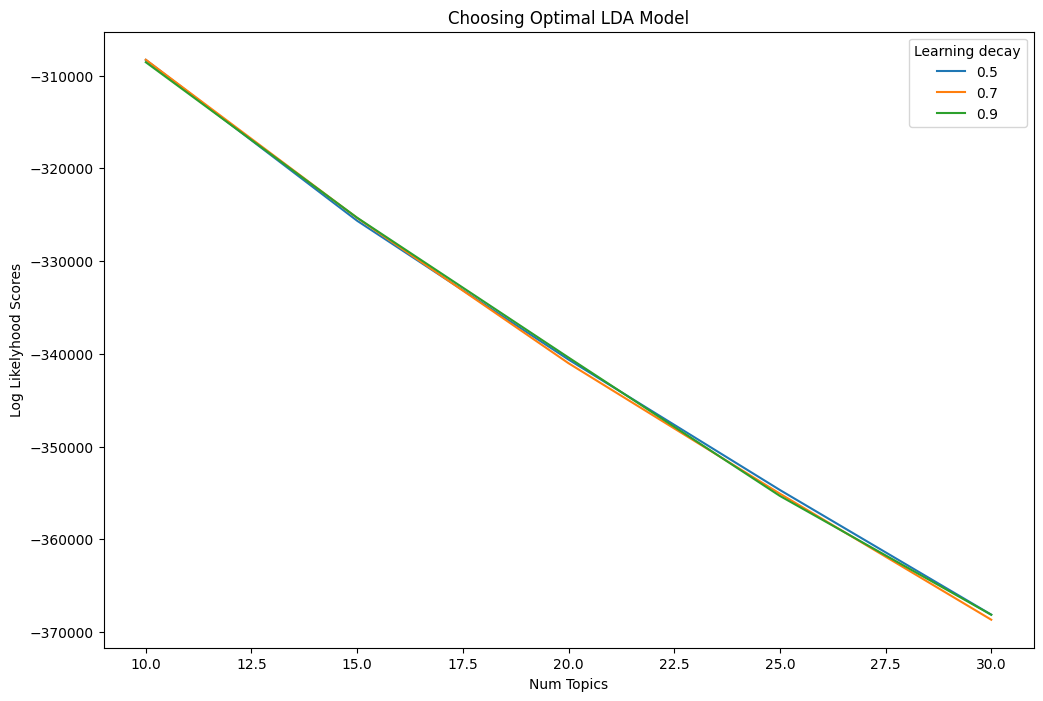

In [12]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

### LDA (2) using gensim

In [13]:
# create a list of tokenized reviews without stop words
tokenized_reviews = []
stop_words = set(stopwords.words('english'))
for review in df['clean_reviews']:
    tokens = word_tokenize(review)
    tokens_without_stopwords = [token.lower() for token in tokens if token.lower() not in stop_words]
    tokenized_reviews.append(tokens_without_stopwords)

# create the id2word dictionary
id2word = corpora.Dictionary(tokenized_reviews)

# create the corpus
corpus = [id2word.doc2bow(tokens) for tokens in tokenized_reviews]

# create the LDA model
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=10)

# visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/envs/data-dialogue2/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.108619 -0.034656       1        1  28.521621
5      0.039535  0.087970       2        1  11.686201
2      0.080525 -0.002731       3        1  10.022689
1      0.150973  0.168304       4        1   9.996880
8     -0.015652 -0.010886       5        1   8.849627
0      0.013971 -0.105598       6        1   8.204007
7      0.002376 -0.172102       7        1   8.108607
4     -0.024435 -0.015808       8        1   6.069452
6     -0.129788 -0.044020       9        1   4.756558
3     -0.226123  0.129526      10        1   3.784358, topic_info=        Term         Freq        Total Category  logprob  loglift
121   coffee  1046.000000  1046.000000  Default  30.0000  30.0000
676      tea   823.000000   823.000000  Default  29.0000  29.0000
659    price   968.000000   968.000000  Default  28.0000  28.0000
7       food   667.000000   667.000000  Default  27.0000  27.0000
146    great  1495.000000  1495.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
989   buying    26.427685   263.906401  Topic10  -5.5408   0.9731
301    could    28.239339   465.067153  Topic10  -5.4745   0.4728
322     last    23.122191   159.384441  Topic10  -5.6744   1.3438
1511  around    22.325059   149.894618  Topic10  -5.7095   1.3701
309     even    23.798152   683.761878  Topic10  -5.6456  -0.0837

[722 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7907      6  0.897659   12pack
1377      1  0.092369       16
1377      3  0.877501       16
2534      6  0.896542      250
1991      3  0.945000       2g
...     ...       ...      ...
81        8  0.025321    would
81        9  0.003724    would
81       10  0.002234    would
741       2  0.954959    yeast
5345     10  0.826356  zealand

[1860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 3, 2, 9, 1, 8, 5, 7, 4])

### NER (Named Entity Recognition)

In [14]:
nlp = spacy.load("en_core_web_sm")

#### Pet products

In [15]:
def extract_pet_entities(text):
    doc = nlp(text)
    pet_entities = []
    for entity in doc.ents:
        if entity.label_ == "ANIMAL" or "pet" in entity.text.lower() or "dog" in entity.text.lower() or "cat" in entity.text.lower():
            pet_entities.append(entity.text)
    return pet_entities

# apply the extract_pet_entities function to the reviews column
df['pet_entities'] = df['clean_reviews'].apply(extract_pet_entities)

# print the unique pet-related entities that were extracted
pet_entities = set([entity for row in df['pet_entities'] for entity in row])
print(pet_entities)

{'winston tenacious bulldog', 'dogswell usa', 'gary peterson', 'two dogs weeks', 'vet wanted supplement dogs supplement', '3adogswell', 'petco', 'moscato', 'every january vacation christmas', '5 dogs kibbles', 'peter pan brand'}


In [16]:
print(len(pet_entities))

11


In [17]:
df.drop(['pet_entities'], inplace = True, axis = 1)

In [18]:
def extract_product_entities(text):
    doc = nlp(text)
    product_entities = []
    for entity in doc.ents:
        if entity.label_ == "PRODUCT" or "coffee" in entity.text.lower() or "tea" in entity.text.lower() or "caffeine" in entity.text.lower():
            product_entities.append(entity.text)
    return product_entities


Next steps:
- Explore the brand these reviews are for
- Try to pin down the exact company
- Knowing the domain that this dataset is for, use transfer learning to build a relevant pre-trained model to improve.